<a href="https://colab.research.google.com/github/Peter-obi/JAX/blob/main/Vmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import jax
import jax.numpy as jnp

In [3]:
def dot(v1, v2):
  return jnp.vdot(v1, v2) #use vdot() to calculate the dot product

In [4]:
dot(jnp.array([1., 1., 1.]), jnp.array([1., 2., -1]))  #calculates th edot product between 2 vectors

Array(2., dtype=float32)

In [4]:
rng_key = jax.random.PRNGKey(42) #generates a random number generator key

In [5]:
vs = jax.random.normal(rng_key, shape =(20, 3)) #generate a two-dimensional array of random numbers

In [6]:
v1s = vs[:10, :] #split array into two parts; the first 10 go the first list and the second 10 go to the second list
v2s = vs[10:, :]

##Vectorization

In [11]:
#naive vectorization to two lists of vectors
v1s.shape, v2s.shape

((10, 3), (10, 3))

In [12]:
dot(v1s, v2s) #one number - wrong answer

Array(0.09785453, dtype=float32)

In [13]:
#Naive generation of results one item at a time
[dot(v1s[i], v2s[i]) for i in range(v1s.shape[0])] #apply the function elementwise in a python list comprehension gives list of arrays instead of single array

[Array(-0.21668759, dtype=float32),
 Array(0.0147948, dtype=float32),
 Array(-0.7736949, dtype=float32),
 Array(-0.37052184, dtype=float32),
 Array(-0.19051453, dtype=float32),
 Array(-0.44745094, dtype=float32),
 Array(-1.2089032, dtype=float32),
 Array(1.1151277, dtype=float32),
 Array(0.02767059, dtype=float32),
 Array(2.1480343, dtype=float32)]

In [14]:
#manual vectorization
def dot_vectorized(v1s, v2s):
  return jnp.einsum('ij, ij -> i', v1s, v2s)  #rewritten to support arrays as inputs

In [15]:
dot_vectorized(v1s, v2s)

Array([-0.21668759,  0.0147948 , -0.7736949 , -0.37052184, -0.19051453,
       -0.44745094, -1.2089032 ,  1.1151277 ,  0.02767059,  2.1480343 ],      dtype=float32)

In [16]:
#automatic vmap
dot_vmapped = jax.vmap(dot)

In [17]:
dot_vmapped(v1s, v2s)

Array([-0.21668759,  0.0147948 , -0.7736949 , -0.37052184, -0.19051453,
       -0.44745094, -1.2089032 ,  1.1151277 ,  0.02767059,  2.1480343 ],      dtype=float32)

In [18]:
%timeit [dot(v1s[i], v2s[i]).block_until_ready() for i in range(v1s.shape[0])]

2.97 ms ± 411 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit dot_vectorized(v1s, v2s).block_until_ready()

222 µs ± 5.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%timeit dot_vmapped(v1s, v2s).block_until_ready

573 µs ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
#JIT both functions
dot_vectorized_jitted = jax.jit(dot_vectorized)
dot_vmapped_jitted = jax.jit(dot_vmapped)

In [23]:
#warmup
dot_vectorized_jitted(v1s, v2s);
dot_vmapped_jitted(v1s, v2s);

In [24]:
%timeit dot_vectorized_jitted(v1s, v2s).block_until_ready()

11.7 µs ± 2.51 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
%timeit dot_vmapped_jitted(v1s, v2s).block_until_ready

10.2 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


##jaxpr for the dot products

In [26]:
jax.make_jaxpr(dot) (jnp.array([1., 1., 1.]), jnp.array([1., 1., -1]))

{ lambda ; a:f32[3] b:f32[3]. let
    c:f32[] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      preferred_element_type=float32
    ] a b
  in (c,) }

In [27]:
jax.make_jaxpr(dot_vectorized) (v1s, v2s)

{ lambda ; a:f32[10,3] b:f32[10,3]. let
    c:f32[10] = dot_general[
      dimension_numbers=(([1], [1]), ([0], [0]))
      preferred_element_type=float32
    ] a b
  in (c,) }

In [28]:
jax.make_jaxpr(dot_vmapped) (v1s, v2s) #dot general - from jax.lax

{ lambda ; a:f32[10,3] b:f32[10,3]. let
    c:f32[10] = dot_general[
      dimension_numbers=(([1], [1]), ([0], [0]))
      preferred_element_type=float32
    ] a b
  in (c,) }

##in_ and out_ axes parameter

In [33]:
def scaled_dot(v1, v2, koeff):
  return koeff * jnp.vdot(v1, v2)
v1s_ = v1s
v2s_ = v2s.T
k = 1.0 #identity since coefficient is 1

In [34]:
v1s_.shape, v2s_.shape

((10, 3), (3, 10))

In [35]:
scaled_dot_batched = jax.vmap(scaled_dot, in_axes=(0,1,None)) #for first paranter, iterate over axis = 0

In [36]:
scaled_dot_batched(v1s_, v2s_, k)

Array([-0.21668759,  0.0147948 , -0.7736949 , -0.37052184, -0.19051453,
       -0.44745094, -1.2089032 ,  1.1151277 ,  0.02767059,  2.1480343 ],      dtype=float32)

In [37]:
def scaled_dot(data, koeff):
  return koeff*jnp.vdot(data['a'], data['b']) #now the functon consumes a dict and a scalar

In [39]:
scaled_dot_batched = jax.vmap(scaled_dot, in_axes =({'a':0, 'b': 1}, None)) #marks axes for dict and scalar

In [40]:
scaled_dot_batched({'a': v1s_, 'b':v2s_}, k)

Array([-0.21668759,  0.0147948 , -0.7736949 , -0.37052184, -0.19051453,
       -0.44745094, -1.2089032 ,  1.1151277 ,  0.02767059,  2.1480343 ],      dtype=float32)

In [41]:
def scale(v, koeff):
  return koeff*v

In [42]:
scale_batched = jax.vmap(scale, in_axes=(0, None), out_axes=(1)) #out_axes - specifies batch dimension for the output

In [43]:
scale_batched(v1s, 2.0)

Array([[-0.05660923,  0.30709183, -2.881758  ,  1.8203408 ,  2.8915725 ,
         1.819189  , -2.8970175 , -2.358762  , -0.48223934, -1.0695378 ],
       [ 0.9342637 , -0.24806564,  1.5117198 , -0.7689932 ,  2.1618133 ,
         1.1146923 ,  1.528375  , -3.8778367 ,  2.430255  ,  0.54135114],
       [ 0.5914059 ,  0.4338463 ,  1.0428193 ,  2.2796466 , -0.11258642,
         0.43811437, -0.48309395,  0.71252924, -2.7904441 ,  3.0802484 ]],      dtype=float32)

In [47]:
#using named arguments
def scale(v, koeff=1.0): #make koeff a named argument
  return koeff*v

In [51]:
scale_batched = jax.vmap(scale, in_axes=(0, None), out_axes=(1))

In [52]:
scale_batched(v1s, koeff=2.0)

ValueError: vmap in_axes must be an int, None, or a tuple of entries corresponding to the positional arguments passed to the function, but got len(in_axes)=2, len(args)=1

In [53]:
scale_batched = jax.vmap(scale, in_axes=(0), out_axes=(1))

In [54]:
scale_batched(v1s, koeff=2.0)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [55]:
from functools import partial

scale2 = partial(scale, koeff=2.0) #make a partial function with a fixed koeff parameter value
scale_batched = jax.vmap(scale2, in_axes=(0), out_axes=(1))
scale_batched(v1s)

Array([[-0.05660923,  0.30709183, -2.881758  ,  1.8203408 ,  2.8915725 ,
         1.819189  , -2.8970175 , -2.358762  , -0.48223934, -1.0695378 ],
       [ 0.9342637 , -0.24806564,  1.5117198 , -0.7689932 ,  2.1618133 ,
         1.1146923 ,  1.528375  , -3.8778367 ,  2.430255  ,  0.54135114],
       [ 0.5914059 ,  0.4338463 ,  1.0428193 ,  2.2796466 , -0.11258642,
         0.43811437, -0.48309395,  0.71252924, -2.7904441 ,  3.0802484 ]],      dtype=float32)

In [56]:
scale_batched = jax.vmap(scale, in_axes=(0), out_axes=(1))

In [57]:
scale_batched(v1s, koeff=jnp.broadcast_to(2.0, (v1s.shape[0],))) #before calling the function, change the named parameter to have an axis to map

Array([[-0.05660923,  0.30709183, -2.881758  ,  1.8203408 ,  2.8915725 ,
         1.819189  , -2.8970175 , -2.358762  , -0.48223934, -1.0695378 ],
       [ 0.9342637 , -0.24806564,  1.5117198 , -0.7689932 ,  2.1618133 ,
         1.1146923 ,  1.528375  , -3.8778367 ,  2.430255  ,  0.54135114],
       [ 0.5914059 ,  0.4338463 ,  1.0428193 ,  2.2796466 , -0.11258642,
         0.43811437, -0.48309395,  0.71252924, -2.7904441 ,  3.0802484 ]],      dtype=float32)

In [7]:
from functools import partial

@partial(jax.vmap, in_axes=(0, None), out_axes=(1)) #works if you care only for the batched function
def scale(v, koeff):
  return koeff*v

scale(v1s, 2.0)

Array([[-0.05660923,  0.30709183, -2.881758  ,  1.8203408 ,  2.8915725 ,
         1.819189  , -2.8970175 , -2.358762  , -0.48223934, -1.0695378 ],
       [ 0.9342637 , -0.24806564,  1.5117198 , -0.7689932 ,  2.1618133 ,
         1.1146923 ,  1.528375  , -3.8778367 ,  2.430255  ,  0.54135114],
       [ 0.5914059 ,  0.4338463 ,  1.0428193 ,  2.2796466 , -0.11258642,
         0.43811437, -0.48309395,  0.71252924, -2.7904441 ,  3.0802484 ]],      dtype=float32)

In [8]:
arr = jnp.array(range(50))
arr

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],      dtype=int32)

In [9]:
norm = jax.vmap(lambda x: x/jax.lax.psum(x, axis_name='batch'), axis_name='batch')

In [10]:
norm(arr)

Array([0.        , 0.00081633, 0.00163265, 0.00244898, 0.00326531,
       0.00408163, 0.00489796, 0.00571429, 0.00653061, 0.00734694,
       0.00816326, 0.00897959, 0.00979592, 0.01061224, 0.01142857,
       0.0122449 , 0.01306122, 0.01387755, 0.01469388, 0.0155102 ,
       0.01632653, 0.01714286, 0.01795918, 0.01877551, 0.01959184,
       0.02040816, 0.02122449, 0.02204082, 0.02285714, 0.02367347,
       0.0244898 , 0.02530612, 0.02612245, 0.02693878, 0.0277551 ,
       0.02857143, 0.02938776, 0.03020408, 0.03102041, 0.03183673,
       0.03265306, 0.03346939, 0.03428571, 0.03510204, 0.03591837,
       0.03673469, 0.03755102, 0.03836735, 0.03918367, 0.04      ],      dtype=float32)

##Data augmentation

In [11]:
add_noise_func = lambda x: x+10
horizontal_flip_func = lambda x: x+1
rotate_func = lambda x: x+2
adjust_colors_func = lambda x: x+3

In [12]:
augmentations = [add_noise_func, horizontal_flip_func, rotate_func, adjust_colors_func]

In [15]:
def random_augmentation(image, augmentations, rng_key):
  """A function that applies a random augmentation to an image"""
  augmentation_index = jax.random.randint(key=rng_key, minval=0, maxval=len(augmentations), shape=())
  augmented_image = jax.lax.switch(augmentation_index, augmentations, image)
  return augmented_image

In [17]:
image = jnp.array(range(100))
augmented_image = random_augmentation(image, augmentations, jax.random.PRNGKey(211))

In [18]:
images = jnp.repeat(jnp.reshape(image, (1, len(image))), 10, axis=0)
images.shape

(10, 100)

In [19]:
rng_keys = jax.random.split(jax.random.PRNGKey(211), num=len(images)) #generates an array of random number generator keys

In [20]:
random_augmentation_batch = jax.vmap(random_augmentation, in_axes=(0, None, 0)) #auto-vectorizes the function
augmented_images = random_augmentation_batch(images, augmentations, rng_keys) #applies the vectorization to a batch

##NN predictions batching

In [7]:
import jax.numpy as jnp
from jax.nn import swish
from jax import vmap, jit, grad, random

In [3]:
def predict(params, image):
  """Function for per-example predictions"""
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs)
  final_w, final_b = params[:-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

In [4]:
batched_predict = vmap(predict, in_axes=(None, 0)) #works with image batches

##Per sample gradients and batching

In [8]:
x = jnp.linspace(0, 10*jnp.pi, num=1000)
e = 10.0*random.normal(random.PRNGKey(42), shape=x.shape)
y = 65.0 * 1.8*x + 40*jnp.cos(x) + e

In [9]:
model_parameters = jnp.array([1., 1.])

In [10]:
def predict(theta, x):
  w, b = theta
  return w * x + b

In [11]:
def loss_fn(model_parameters, x, y): #function to compute prediction error on a single example
  prediction = predict(model_parameters, x)
  return (prediction - y)**2

In [12]:
grads_fn = jit(vmap(grad(loss_fn), in_axes=(None, 0, 0))) #make a JIT-compiled batched version of the gradient calculation function

In [13]:
batch_x, batch_y = x[:32], y[:32]

In [14]:
grads_fn(model_parameters, batch_x, batch_y)

Array([[   0.       ,  -77.43391  ],
       [  -2.9748862,  -94.59888  ],
       [  -6.1855392,  -98.34747  ],
       [  -9.679741 , -102.60254  ],
       [ -13.090965 , -104.07042  ],
       [ -18.527302 , -117.83052  ],
       [ -17.27165  ,  -91.53732  ],
       [ -31.315313 , -142.25723  ],
       [ -36.296852 , -144.27617  ],
       [ -44.911385 , -158.6827   ],
       [ -43.82026  , -139.34473  ],
       [ -60.989777 , -176.31123  ],
       [ -71.26084  , -188.83623  ],
       [ -76.80456  , -187.87079  ],
       [ -75.45512  , -171.38637  ],
       [ -92.87611  , -196.89214  ],
       [ -98.601204 , -195.9647   ],
       [-104.38017  , -195.24716  ],
       [ -95.02668  , -167.87602  ],
       [-130.28091  , -218.04333  ],
       [-128.16483  , -203.77667  ],
       [-126.00598  , -190.804    ],
       [-125.45505  , -181.33478  ],
       [-168.45348  , -232.89908  ],
       [-170.98772  , -226.55272  ],
       [-205.36815  , -261.22137  ],
       [-175.38379  , -214.50218  ],
 

##Vectorizing loops

In [16]:
from jax.scipy.signal import convolve2d
from skimage.io import imread
from skimage.util import img_as_float32
import matplotlib.pyplot as plt

In [17]:
kernel_blur = jnp.ones((5, 5))
kernel_blur /= jnp.sum(kernel_blur)

In [27]:
def color_convolution(image, kernel): #Apply a filter kernel to a color image
  channels = []
  for i in range(3):
    color_channel = image[:,:,i]
    filtered_channel = convolve2d(color_channel, kernel, mode='same')
    filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
    channels.append(filtered_channel)
  final_image = jnp.stack(channels, axis=2)
  return final_image

In [23]:
img = img_as_float32(imread('The_Cat.jpg'))

In [28]:
img_blur = color_convolution(img, kernel_blur)

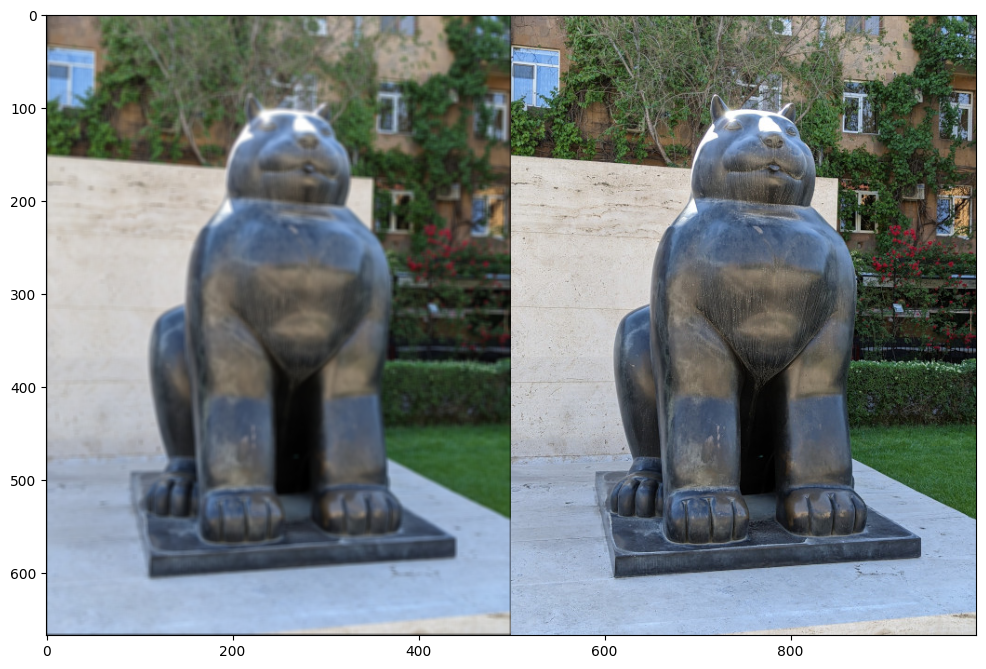

In [29]:
plt.figure(figsize=(12, 10))
plt.imshow(jnp.hstack((img_blur, img)))

In [30]:
def matrix_filter(channel, kernel):
  filtered_channel = convolve2d(channel, kernel, mode='same')
  filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
  return filtered_channel

color_convolution_vmap = vmap(matrix_filter, in_axes=(2, None), out_axes=2)

In [31]:
img = img_as_float32(imread('The_Cat.jpg'))

In [32]:
img_blur = color_convolution_vmap(img, kernel_blur)

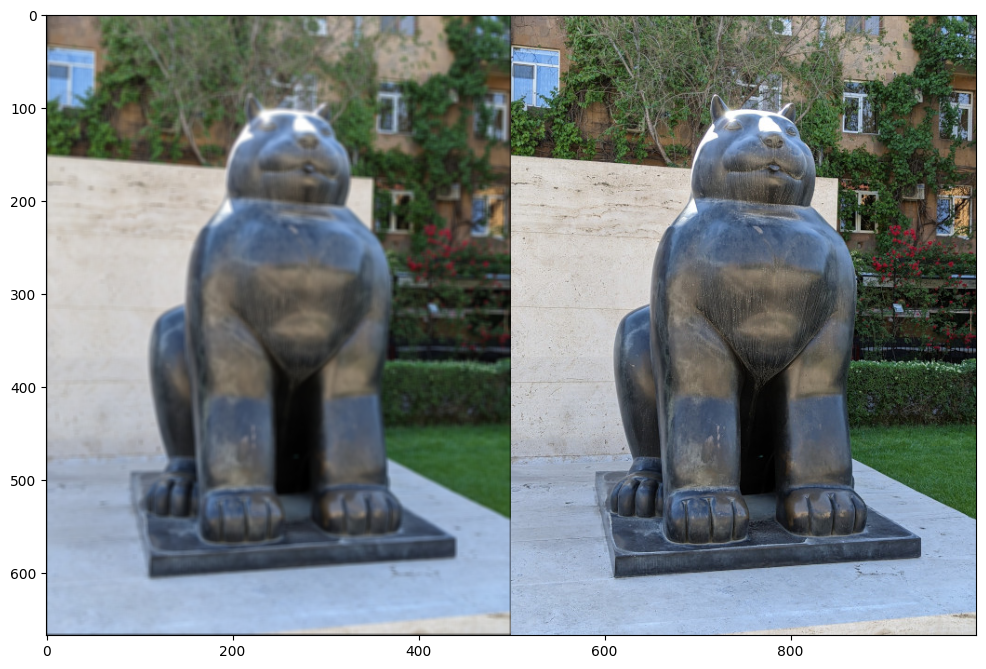

In [33]:
plt.figure(figsize=(12, 10))
plt.imshow(jnp.hstack((img_blur, img)))

In [35]:
%timeit color_convolution(img, kernel_blur).block_until_ready()

166 ms ± 42.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%timeit color_convolution_vmap(img, kernel_blur).block_until_ready()

128 ms ± 29.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
color_convolution_jit = jit(color_convolution)
color_convolution_vmap_jit = jit(color_convolution_vmap)

In [39]:
color_convolution_jit(img, kernel_blur);
color_convolution_vmap_jit(img, kernel_blur);

In [40]:
%timeit color_convolution_jit(img, kernel_blur).block_until_ready()

140 ms ± 38.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit color_convolution_vmap_jit(img, kernel_blur).block_until_ready()

108 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
